In [1]:
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module

In [2]:
# Start Dask client
client = Client(n_workers=4, threads_per_worker=1, memory_limit='4GB')

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35927
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42257'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42509'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45203'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43875'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37447 name: 2
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37447
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:46126
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34961 name: 1
INFO:

In [3]:
# Generate synthetic data (in practice load from Parquet/CSV)
num_rows = 10_000_000
chunk_size = 1_000_000

In [4]:
# Create Dask DataFrame
df = dd.from_pandas(pd.DataFrame({
    'transaction_id': range(1, num_rows + 1),
    'customer_id': np.random.randint(1, 100000, size=num_rows),
    'product_id': np.random.randint(1, 5000, size=num_rows),
    'purchase_amount': np.random.normal(100, 50, size=num_rows),
    'region': np.random.choice(['North', 'South', 'East', 'West', 'Central'], size=num_rows),
    'purchase_date': pd.to_datetime('today') - pd.to_timedelta(np.random.randint(0, 365, size=num_rows), unit='D')
}), chunksize=chunk_size)

In [5]:
# Persist in memory
df = df.persist()

/usr/local/lib/python3.11/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 505.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [6]:
# Basic statistics
print(df.describe().compute())

       transaction_id   customer_id    product_id  purchase_amount  \
count    1.000000e+07  1.000000e+07  1.000000e+07     1.000000e+07   
mean     5.000000e+06  5.002601e+04  2.499846e+03     9.999288e+01   
std      2.886751e+06  2.886716e+04  1.442928e+03     5.000248e+01   
min      1.000000e+00  1.000000e+00  1.000000e+00    -1.502564e+02   
25%      2.500000e+06  2.510200e+04  1.254000e+03     6.634840e+01   
50%      5.000000e+06  5.010500e+04  2.502000e+03     1.000781e+02   
75%      7.500000e+06  7.507400e+04  3.751000e+03     1.338376e+02   
max      1.000000e+07  9.999900e+04  4.999000e+03     3.701826e+02   

                       purchase_date  
count                       10000000  
mean                             NaN  
std                              NaN  
min       2024-05-19 10:31:46.570924  
25%    2024-08-18 10:31:46.570924032  
50%    2024-11-17 10:31:46.570924032  
75%    2025-02-17 10:31:46.570924032  
max       2025-05-18 10:31:46.570924  


In [8]:
# Top products analysis
top_products = df.groupby('product_id')['purchase_amount'] \
    .agg(['count', 'sum']) \
    .rename(columns={'count': 'transactions', 'sum': 'revenue'}) \
    .nlargest(10, 'revenue')
print(top_products.compute())

            transactions        revenue
product_id                             
293                 2162  219047.791593
1558                2143  217949.066804
4405                2134  216801.709763
1913                2139  215866.502118
1383                2141  215371.040362
4713                2106  215076.110778
2863                2101  214831.925530
4999                2111  214679.953053
3726                2131  214537.363824
4268                2127  214371.714171


In [9]:
# Time-based analysis
daily_sales = df.groupby('purchase_date')['purchase_amount'].sum().compute()

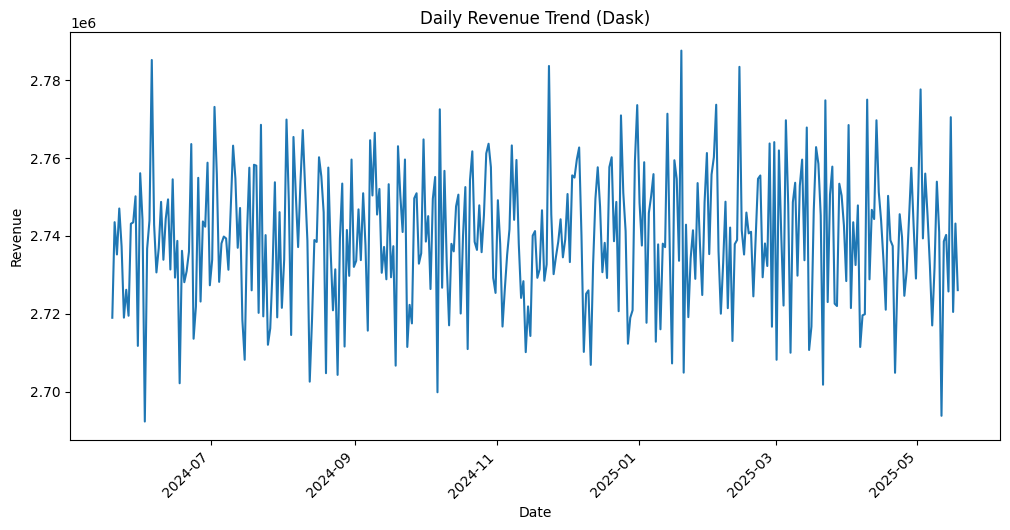

In [10]:
# Visualization
plt.figure(figsize=(12, 6)) # Now plt is defined and can be used
daily_sales.plot()
plt.title('Daily Revenue Trend (Dask)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

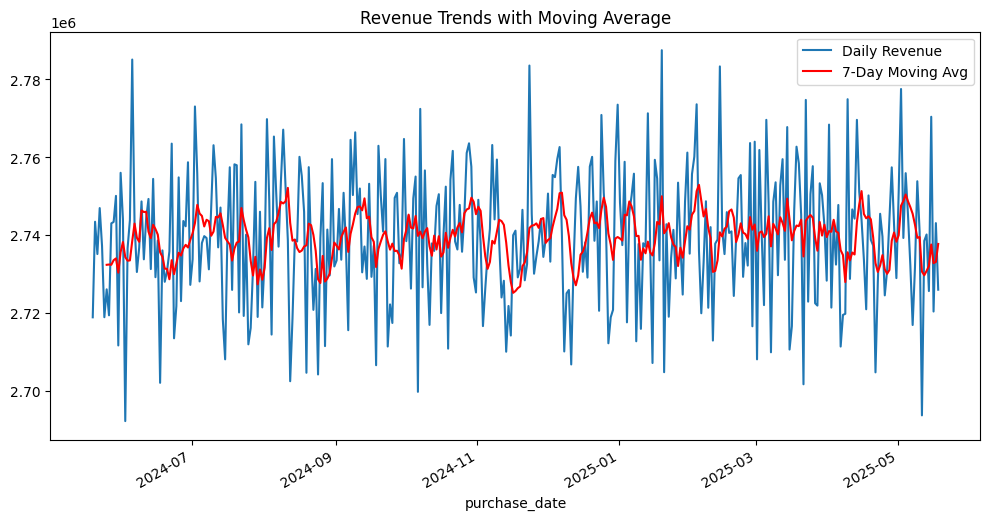

In [11]:
# Complex operation: Rolling 7-day average
# This demonstrates Dask's ability to handle window functions on large data
rolling_avg = daily_sales.rolling(7).mean()

plt.figure(figsize=(12, 6))
daily_sales.plot(label='Daily Revenue')
rolling_avg.plot(label='7-Day Moving Avg', color='red')
plt.title('Revenue Trends with Moving Average')
plt.legend()
plt.show()

In [12]:
# Close Dask client
client.close()

INFO:distributed.scheduler:Remove client Client-ebea4856-33d2-11f0-8140-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:46162; closing.
INFO:distributed.scheduler:Remove client Client-ebea4856-33d2-11f0-8140-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-ebea4856-33d2-11f0-8140-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1747564520.01842') (0, 1, 2, 3)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42257'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42509'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45203'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43875'. 

In [13]:
from pyspark.sql import SparkSession

# Initialize Spark Session with proper line continuation
spark = (SparkSession.builder
    .appName("EcommerceAnalysis")
    .master("local[*]")  # Use "local[*]" for local, "yarn" for cluster
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.shuffle.partitions", "8")  # For better parallelism
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")  # Better Pandas integration
    .getOrCreate())

In [14]:
spark = (SparkSession.builder
    .appName("ClusterAnalysis")
    .master("spark://your-cluster-master:7077")  # Cluster URL
    .config("spark.executor.instances", "8")
    .config("spark.executor.cores", "4")
    .config("spark.executor.memory", "8g")
    .getOrCreate())

In [15]:
# Test the Spark session is working
test_df = spark.range(1, 100).toDF("id")
print(f"Spark version: {spark.version}")
print(f"Partition count: {test_df.rdd.getNumPartitions()}")
test_df.show(5)

Spark version: 3.5.1
Partition count: 2
+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
+---+
only showing top 5 rows

